### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Loading Preprocessed Data

In [3]:
df_preprocessed = pd.read_csv('../data/processed_heart_disease.csv')


X = df_preprocessed.drop('target', axis=1)
y = df_preprocessed['target']


print("Preprocessed DataFrame shape:", df_preprocessed.shape)
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst few rows of features (X):")
print(X.head())
print("\nTarget value counts:")
print(y.value_counts())

Preprocessed DataFrame shape: (920, 14)
Features (X) shape: (920, 13)
Target (y) shape: (920,)

First few rows of features (X):
    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0    1   1     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0    1   4     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0    1   4     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0    1   3     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0    0   2     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  
0    3.0  0.0   6.0  
1    2.0  3.0   3.0  
2    2.0  2.0   7.0  
3    3.0  0.0   3.0  
4    1.0  0.0   3.0  

Target value counts:
target
1    509
0    411
Name: count, dtype: int64


### Method 1: Feature Importance using Random Forest

--- Method 1: Random Forest Feature Importance ---
Feature Importances (Top 10):
     Feature  Importance
2         cp    0.159595
4       chol    0.149048
7    thalach    0.131770
0        age    0.117448
9    oldpeak    0.105538
3   trestbps    0.081976
8      exang    0.080306
12      thal    0.039738
1        sex    0.036622
6    restecg    0.030368


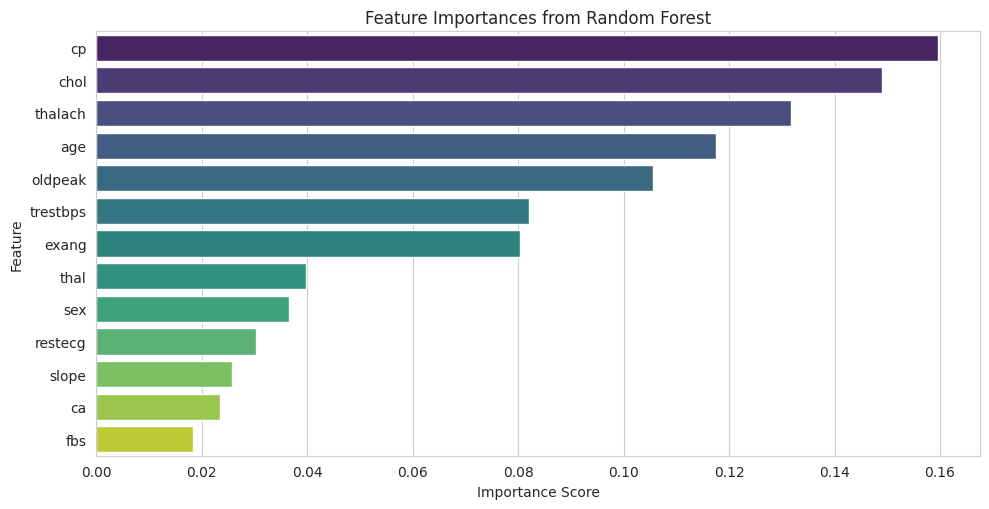

In [7]:
print("--- Method 1: Random Forest Feature Importance ---")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


rf_model.fit(X, y)

importances = rf_model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances (Top 10):")
print(importance_df.head(10))

plt.figure(figsize=(10, len(importance_df) * 0.4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

rf_importance_df = importance_df.copy()



### Method 2: Recursive Feature Elimination (RFE) 


--- Method 2: Recursive Feature Elimination (RFE) ---
Top 10 features selected by RFE:
     Feature  Ranking
0        age        1
1        sex        1
2         cp        1
3   trestbps        1
4       chol        1
6    restecg        1
7    thalach        1
8      exang        1
12      thal        1
9    oldpeak        1

RFE Rankings (Top 10):
     Feature  Ranking
0        age        1
1        sex        1
2         cp        1
3   trestbps        1
4       chol        1
6    restecg        1
7    thalach        1
8      exang        1
12      thal        1
9    oldpeak        1

list of RFE selected features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'thal']


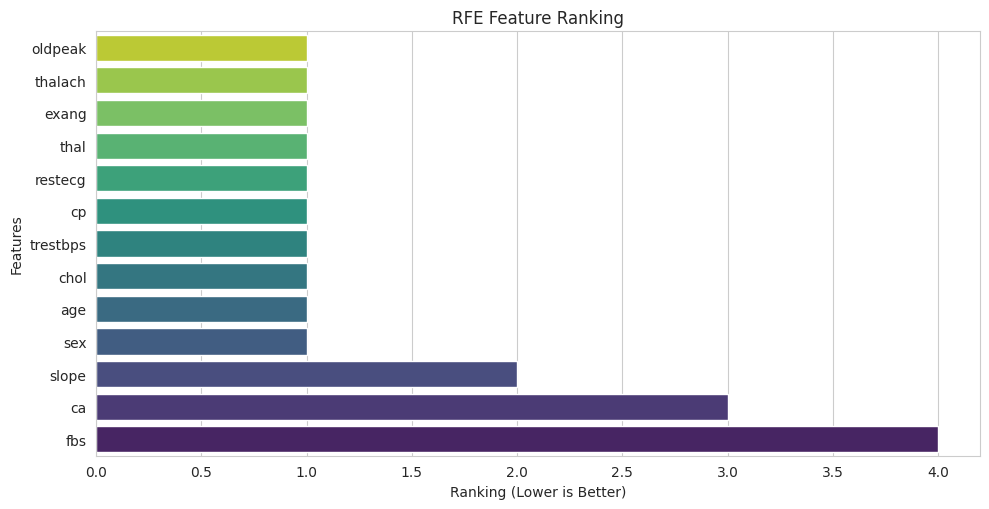

In [15]:
print("\n--- Method 2: Recursive Feature Elimination (RFE) ---")

estimator = RandomForestClassifier(n_estimators=50, random_state=42)

n_features_to_select = 10

rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)

rfe.fit(X, y)

selected_features_mask = rfe.support_

feature_rankings = rfe.ranking_

rfe_df = pd.DataFrame({
    'Feature': feature_names,
    'Selected': selected_features_mask,
    'Ranking': feature_rankings
})
rfe_df = rfe_df.sort_values(by="Ranking")

print(f"Top {n_features_to_select} features selected by RFE:")
print(rfe_df[rfe_df['Selected'] == True][['Feature', 'Ranking']])

print("\nRFE Rankings (Top 10):")
print(rfe_df[['Feature', 'Ranking']].head(10))

rfe_selected_features = X.columns[selected_features_mask].tolist()
print(f"\nlist of RFE selected features: {rfe_selected_features}")


top_n_for_plot = min(15, len(rfe_df))
plt.figure(figsize=(10, top_n_for_plot * 0.4))
sns.barplot(x="Ranking", y="Feature", data=rfe_df.head(top_n_for_plot).sort_values(by="Ranking", ascending=False), palette="viridis")
plt.title(f"RFE Feature Ranking")
plt.xlabel('Ranking (Lower is Better)')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Method 3: Chi-Square Test:

In [ ]:
print("\n--- Method 3: Chi-Square Test (SelectKBest) ---")


X_chi2 = X 
y_chi2 = y 

if (X_chi2 < 0).any().any():
    print("WARNING: X_chi2 contains negative values. Chi-Square test might fail or give incorrect results.")
    print("Please load the unscaled version of X using Option 1 or 3 described above.")
    chi2_selected_features = []
    chi2_df = pd.DataFrame()
else:
    print("X_chi2 appears to be non-negative. Proceeding with Chi-Square test.")

    try:
        
       k_chi2 = 10 

       selector_chi2 = SelectKBest(score_func=chi2, k=k_chi2)

       selector_chi2.fit(X_chi2, y_chi2)

       chi2_scores = selector_chi2.scores_
        chi2_pvalues = selector_chi2.pvalues_

       feature_names_chi2 = X_chi2.columns

        chi2_df = pd.DataFrame({
            'Feature': feature_names_chi2,
            'Chi2_Score': chi2_scores,
            'P_Value': chi2_pvalues
        })
        chi2_df = chi2_df.sort_values(by='Chi2_Score', ascending=False)

        selected_chi2_mask = selector_chi2.get_support()

        print(f"Top {k_chi2} features selected by Chi-Square Test:")
        print(chi2_df[selected_chi2_mask][['Feature', 'Chi2_Score', 'P_Value']])

        print("\nChi-Square Scores (Top 10):")
        print(chi2_df[['Feature', 'Chi2_Score', 'P_Value']].head(10))


        chi2_selected_features = X_chi2.columns[selected_chi2_mask].tolist()
        print(f"\nList of Chi-Square selected features: {chi2_selected_features}")


        plt.figure(figsize=(10, len(chi2_df.head(k_chi2)) * 0.4))
        sns.barplot(x='Chi2_Score', y='Feature', data=chi2_df.head(k_chi2), palette='viridis')
        plt.title(f'Chi-Square Test Scores (Top {k_chi2})')
        plt.xlabel('Chi-Square Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Error applying Chi-Square test: {e}")
        print("This usually happens if features contain negative values.")
        chi2_selected_features = []
        chi2_df = pd.DataFrame()


--- Method 3: Chi-Square Test (SelectKBest) ---
Note: Chi-Square requires non-negative features. Ensure your data meets this criterion.
Please load the unscaled version of X using Option 1 or 3 described above.


### Comparing and Selecting Final Features:

In [18]:
print("\n--- Comparing Feature Selection Methods ---")

all_selected = set()
if 'rf_importance_df' in locals():
    all_selected.update(rf_importance_df.head(10)['Feature'].tolist())
if 'rfe_selected_features' in locals():
    all_selected.update(rfe_selected_features)
if 'chi2_selected_features' in locals() and chi2_selected_features:
    all_selected.update(chi2_selected_features)
    
print(f"Features selected by at least one method (top ranks): {list(all_selected)}")


final_selected_features = rf_importance_df.head(10)['Feature'].tolist()
print(f"\nFinal selected features (Top 10 RF Importance): {final_selected_features}")

X_final = X[final_selected_features]

print(f"\nFinal reduced feature set shape: {X_final.shape}")
print("Final selected features:")
print(X_final.head())


--- Comparing Feature Selection Methods ---
Features selected by at least one method (top ranks): ['age', 'trestbps', 'chol', 'cp', 'thalach', 'oldpeak', 'thal', 'sex', 'exang', 'restecg']

Final selected features (Top 10 RF Importance): ['cp', 'chol', 'thalach', 'age', 'oldpeak', 'trestbps', 'exang', 'thal', 'sex', 'restecg']

Final reduced feature set shape: (920, 10)
Final selected features:
   cp   chol  thalach   age  oldpeak  trestbps  exang  thal  sex  restecg
0   1  233.0    150.0  63.0      2.3     145.0    0.0   6.0    1      2.0
1   4  286.0    108.0  67.0      1.5     160.0    1.0   3.0    1      2.0
2   4  229.0    129.0  67.0      2.6     120.0    1.0   7.0    1      2.0
3   3  250.0    187.0  37.0      3.5     130.0    0.0   3.0    1      0.0
4   2  204.0    172.0  41.0      1.4     130.0    0.0   3.0    0      2.0


### Saving Reduced Dataset:

In [21]:
X_final.to_csv('../data/X_selected_features.csv', index=False)
print("\nFinal selected features saved to ../data/X_selected_features.csv")


Final selected features saved to ../data/X_selected_features.csv
